In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from IPython.display import Image  
from six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

In [2]:
# reading data
df1 = pd.read_csv("churn_data.csv")
df2 = pd.read_csv('customer_data.csv')
df3 = pd.read_csv('internet_data.csv')

In [3]:
# merge data
df4 = pd.merge(df1,df2,how='inner',on = 'customerID')
tcm = pd.merge(df4,df3, how='inner', on='customerID')

In [4]:
tcm.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Female,...,Yes,No,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No,Male,...,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Male,...,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Male,...,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Female,...,No,No,No,Fiber optic,No,No,No,No,No,No


In [5]:
tcm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   tenure            7043 non-null   int64  
 2   PhoneService      7043 non-null   object 
 3   Contract          7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   Churn             7043 non-null   object 
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  MultipleLines     7043 non-null   object 
 14  InternetService   7043 non-null   object 
 15  OnlineSecurity    7043 non-null   object 
 16  OnlineBackup      7043 non-null   object 


In [6]:
#since Total Charges is a numeric column, change it to float from object. errors='coerce' as in some part of the dataset there
#are null values
tcm['TotalCharges'] = pd.to_numeric(tcm['TotalCharges'],errors='coerce')

In [7]:
tcm['TotalCharges'].describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

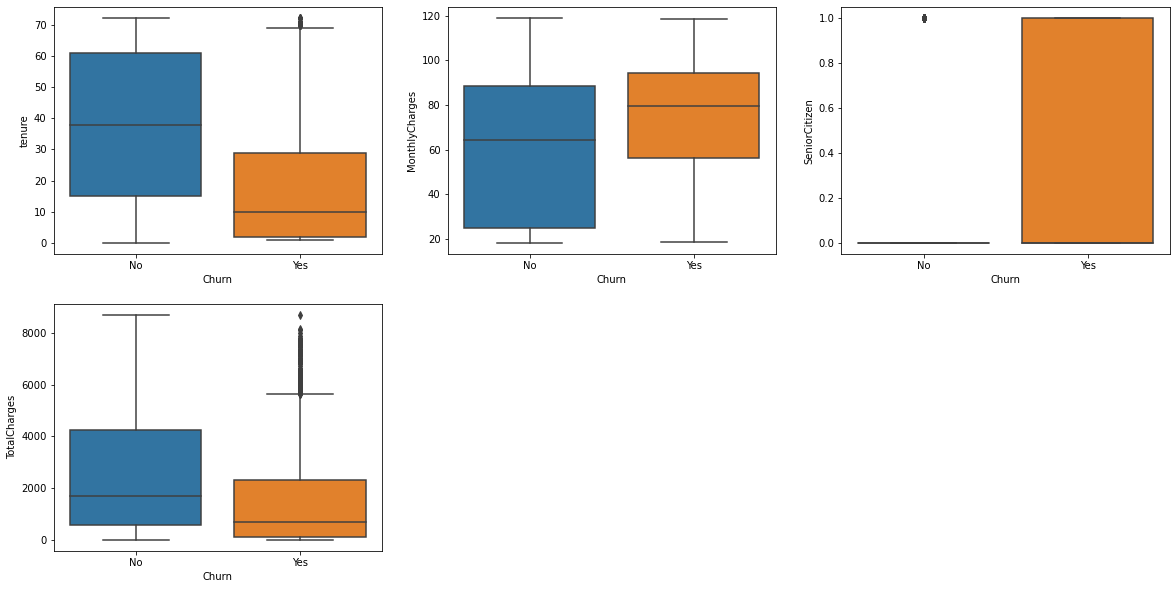

In [8]:
#inspecting each column through EDA
#EDA of num_cols
plt.figure(figsize=(20, 10))  
plt.subplot(2,3,1)
sns.boxplot(x = 'Churn', y = 'tenure', data = tcm)
plt.subplot(2,3,2)
sns.boxplot(x = 'Churn', y = 'MonthlyCharges', data = tcm)
plt.subplot(2,3,3)
sns.boxplot(x = 'Churn', y = 'SeniorCitizen', data = tcm)
plt.subplot(2,3,4)
sns.boxplot(x = 'Churn', y = 'TotalCharges', data = tcm)
plt.show()

In [9]:
#seperating categorical columns
cat_col = tcm.select_dtypes(include=['object']).columns
cat_col

Index(['customerID', 'PhoneService', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'Churn', 'gender', 'Partner', 'Dependents',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [10]:
tcm['PhoneService'].value_counts()

Yes    6361
No      682
Name: PhoneService, dtype: int64

In [11]:
tcm['Contract'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

In [12]:
tcm['PaperlessBilling'].value_counts()

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

In [13]:
tcm['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [14]:
tcm['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [15]:
tcm['Partner'].value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

In [16]:
tcm['Dependents'].value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

In [17]:
tcm['MultipleLines'].value_counts()

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

In [18]:
tcm['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64

In [19]:
tcm['OnlineSecurity'].value_counts()

No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64

In [20]:
tcm['OnlineBackup'].value_counts()

No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64

In [21]:
tcm['DeviceProtection'].value_counts()

No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64

In [22]:
tcm['TechSupport'].value_counts()

No                     3473
Yes                    2044
No internet service    1526
Name: TechSupport, dtype: int64

In [23]:
tcm['StreamingTV'].value_counts()

No                     2810
Yes                    2707
No internet service    1526
Name: StreamingTV, dtype: int64

In [24]:
tcm['StreamingMovies'].value_counts()

No                     2785
Yes                    2732
No internet service    1526
Name: StreamingMovies, dtype: int64

In [25]:
# mapping 1 and 0 to yes and no
variables =  ['PhoneService', 'PaperlessBilling', 'Churn', 'Partner', 'Dependents']

# Defining the map function
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

# Applying the function to the housing list
tcm[variables] = tcm[variables].apply(binary_map)

In [26]:
# mapping 1 and 0 to mal and female
gender =  ['gender']

# Defining the map function
def binary_map(x):
    return x.map({'Male': 1, "Female": 0})

# Applying the function to the housing list
tcm[gender] = tcm[gender].apply(binary_map)

In [27]:
tcm.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,0,Month-to-month,1,Electronic check,29.85,29.85,0,0,...,1,0,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,34,1,One year,0,Mailed check,56.95,1889.50,0,1,...,0,0,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2,1,Month-to-month,1,Mailed check,53.85,108.15,1,1,...,0,0,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,45,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,1,...,0,0,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2,1,Month-to-month,1,Electronic check,70.70,151.65,1,0,...,0,0,No,Fiber optic,No,No,No,No,No,No


In [28]:
#add all numeric columns
num_cols = tcm.select_dtypes(include=['float','int']).columns
num_cols

Index(['tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents'],
      dtype='object')

In [29]:
#update all cat columns
cat_cols_new = tcm.select_dtypes(include=['object']).columns
cat_cols_new

Index(['customerID', 'Contract', 'PaymentMethod', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

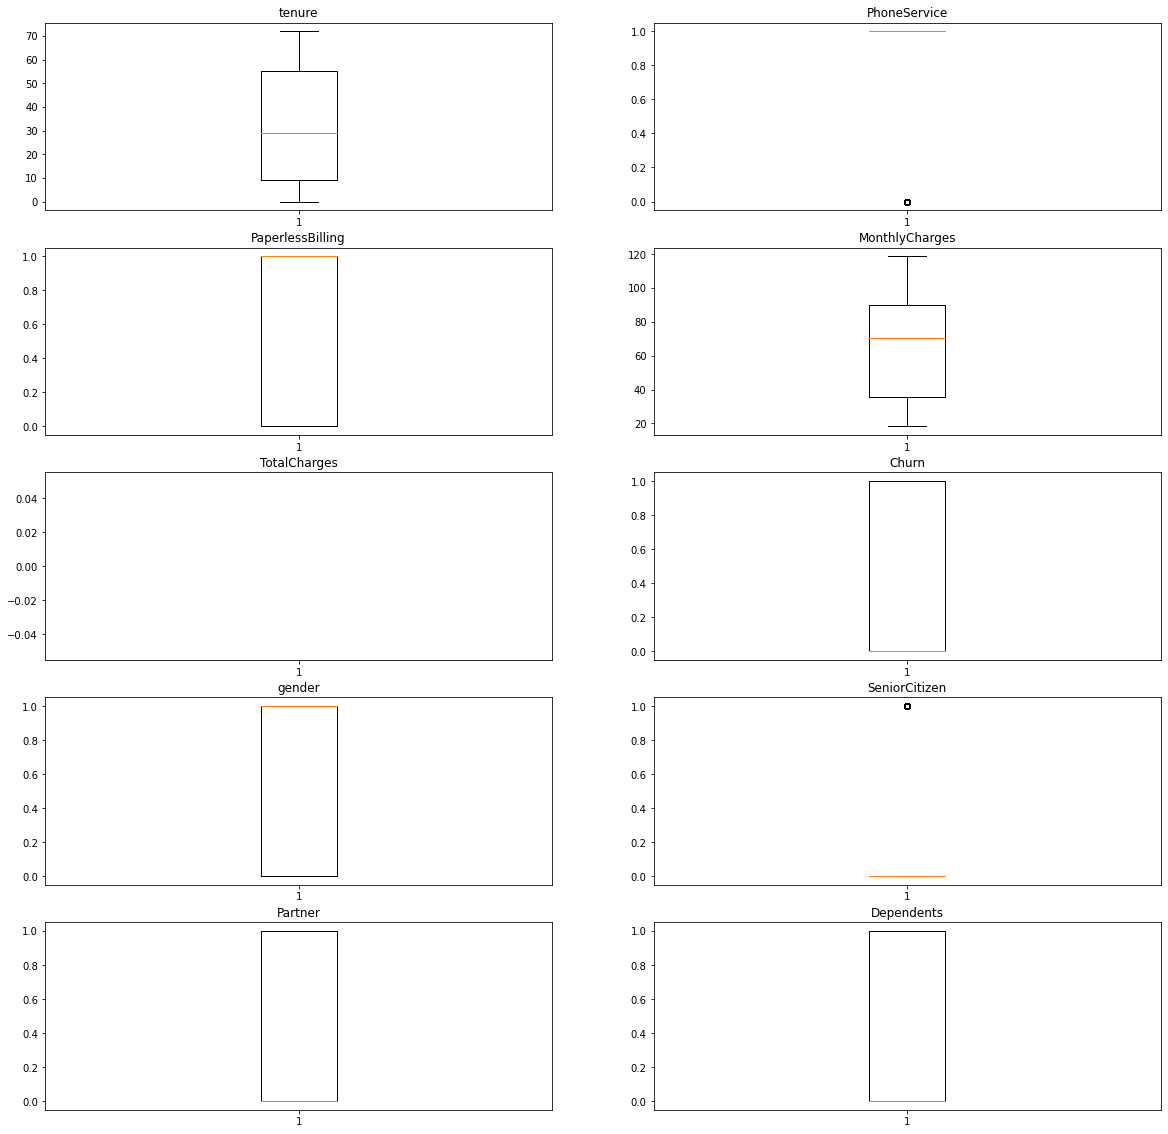

In [30]:
#finding outliers in num_cols
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
axs = axs.ravel()
for i, col in enumerate(num_cols):
    axs[i].boxplot(tcm[col])
    axs[i].set_title(col)

In [31]:
#get categorical columns dummy variables
cat_dummy = pd.get_dummies(tcm[['Contract', 'PaymentMethod', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies']], drop_first=True)

In [32]:
#concatinate dummy variables with original data
tcm = pd.concat([tcm,cat_dummy],axis=1)

In [33]:
#dropping the original columns
tcm = tcm.drop(['Contract', 'PaymentMethod', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies'],1)

In [34]:
tcm.head()

,customerID,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,Partner,...,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
0,7590-VHVEG,1,0,1,29.85,29.85,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
1,5575-GNVDE,34,1,0,56.95,1889.50,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,3668-QPYBK,2,1,1,53.85,108.15,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,7795-CFOCW,45,0,0,42.30,1840.75,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0
4,9237-HQITU,2,1,1,70.70,151.65,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
#checking the nulls
round((tcm.isnull().sum()/len(tcm)*100),2).sort_values(ascending=False)

TotalCharges                             0.16
customerID                               0.00
MultipleLines_Yes                        0.00
StreamingMovies_No internet service      0.00
StreamingTV_Yes                          0.00
StreamingTV_No internet service          0.00
TechSupport_Yes                          0.00
TechSupport_No internet service          0.00
DeviceProtection_Yes                     0.00
DeviceProtection_No internet service     0.00
OnlineBackup_Yes                         0.00
OnlineBackup_No internet service         0.00
OnlineSecurity_Yes                       0.00
OnlineSecurity_No internet service       0.00
InternetService_No                       0.00
InternetService_Fiber optic              0.00
MultipleLines_No phone service           0.00
tenure                                   0.00
PaymentMethod_Mailed check               0.00
PaymentMethod_Electronic check           0.00
PaymentMethod_Credit card (automatic)    0.00
Contract_Two year                 

In [36]:
#dropping nulls
tcm.dropna(inplace=True)

In [37]:
#Rechecking the nulls
round((tcm.isnull().sum()/len(tcm)*100),2).sort_values(ascending=False)

customerID                               0.0
tenure                                   0.0
StreamingMovies_No internet service      0.0
StreamingTV_Yes                          0.0
StreamingTV_No internet service          0.0
TechSupport_Yes                          0.0
TechSupport_No internet service          0.0
DeviceProtection_Yes                     0.0
DeviceProtection_No internet service     0.0
OnlineBackup_Yes                         0.0
OnlineBackup_No internet service         0.0
OnlineSecurity_Yes                       0.0
OnlineSecurity_No internet service       0.0
InternetService_No                       0.0
InternetService_Fiber optic              0.0
MultipleLines_Yes                        0.0
MultipleLines_No phone service           0.0
PaymentMethod_Mailed check               0.0
PaymentMethod_Electronic check           0.0
PaymentMethod_Credit card (automatic)    0.0
Contract_Two year                        0.0
Contract_One year                        0.0
Dependents

In [38]:
#checking the imbalance in data set
tcm['Churn'].value_counts()

0    5163
1    1869
Name: Churn, dtype: int64

In [39]:
from sklearn.utils import resample

In [40]:
#create two different dataframe of majority and minority class 
tcm_majority = tcm[(tcm['Churn']==0)] 
tcm_minority = tcm[(tcm['Churn']==1)] 
# upsample minority class
tcm_minority_upsampled = resample(tcm_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 5163, # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
tcm_upsampled = pd.concat([tcm_minority_upsampled, tcm_majority])

In [41]:
tcm_upsampled.head()

,customerID,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,Partner,...,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
4290,7734-DBOAI,1,0,0,40.10,40.10,1,0,0,1,...,0,0,0,0,0,1,0,1,0,0
5547,9611-CTWIH,3,1,1,89.45,240.45,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3302,7774-OJSXI,31,1,1,103.45,3066.45,1,1,0,0,...,0,1,0,1,0,0,0,1,0,1
4949,3669-LVWZB,5,0,1,51.00,305.95,1,1,0,0,...,0,1,0,0,0,0,0,1,0,1
4307,6899-PPEEA,37,1,1,96.55,3580.30,1,0,1,0,...,0,0,0,0,0,0,0,1,0,1


In [42]:
#Rechecking the imbalance in data set
tcm_upsampled['Churn'].value_counts()

1    5163
0    5163
Name: Churn, dtype: int64

<AxesSubplot:>

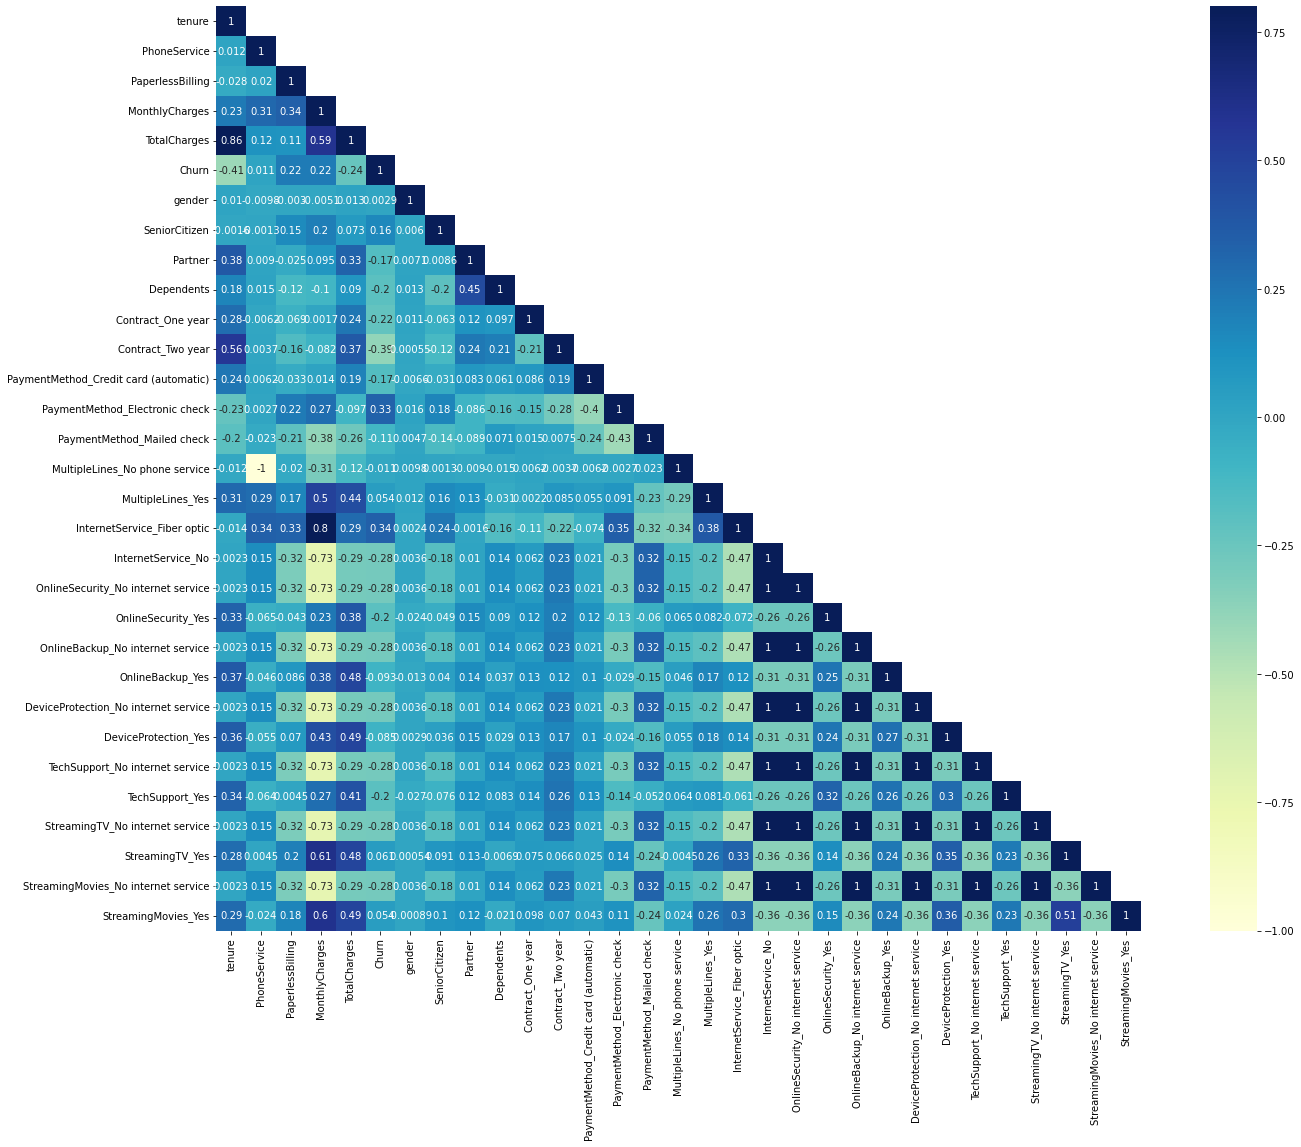

In [43]:
#correlation matrix
mask = np.array(tcm_upsampled.corr())
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(25,17)
sns.heatmap(tcm_upsampled.corr(), mask=mask,vmax=.8, square=True,annot=True,cmap="YlGnBu")

In [44]:
#Train-Test split
X = tcm_upsampled.drop(['Churn','customerID'],axis=1)
y = tcm_upsampled['Churn']

In [45]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

In [46]:
#feature scaling using Min-Max scaler
scaler = MinMaxScaler()
X_train[['tenure','MonthlyCharges','TotalCharges']] = scaler.fit_transform(X_train[['tenure',
                                                                                    'MonthlyCharges','TotalCharges']])
X_train.head()

,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,Contract_One year,...,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
1038,0.774648,1,1,0.623383,0.523736,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
4663,0.042254,1,1,0.563682,0.034958,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3246,0.028169,1,0,0.367164,0.016195,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5059,0.492958,1,1,0.804975,0.415047,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
2771,0.169014,1,1,0.446766,0.092084,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,1


In [47]:
## using RFE CV to find optimal features
rfecv = RFECV(estimator=logreg, cv=5)

In [48]:
rfecv.fit(X_train, y_train)

RFECV(cv=5, estimator=LogisticRegression())

In [49]:
rfecv.grid_scores_

array([0.66949153, 0.7090799 , 0.71731235, 0.73910412, 0.74745763,
       0.75181598, 0.75508475, 0.75399516, 0.75387409, 0.75677966,
       0.75617433, 0.75569007, 0.75532688, 0.75738499, 0.75774818,
       0.75811138, 0.75932203, 0.76004843, 0.75932203, 0.7590799 ,
       0.75895884, 0.75895884, 0.75895884, 0.75956416, 0.75835351,
       0.7598063 , 0.75799031, 0.75920097, 0.75883777, 0.7590799 ])

In [50]:
num_features = X_train.shape
num_features[1]

30

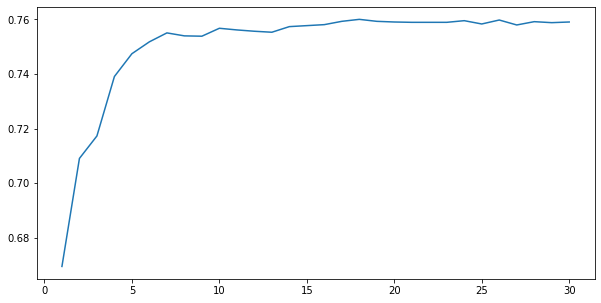

In [51]:
plt.figure(figsize=[10, 5])
plt.plot(range(1, num_features[1]+1), rfecv.grid_scores_)
plt.show()

In [52]:
#model selection of correct number of feature selection
rfecv.n_features_

18

In [53]:
#almost 75% variation is explained by 7-10 features. Thus we will select only 10 features first and then check VIF

In [54]:
#feature selection using RFE
rfe = RFE(logreg, 10)            
rfe = rfe.fit(X_train, y_train)
# Now we will have a look at which features have been selected by the RFE.
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('tenure', True, 1),
 ('PhoneService', False, 13),
 ('PaperlessBilling', True, 1),
 ('MonthlyCharges', False, 9),
 ('TotalCharges', True, 1),
 ('gender', False, 21),
 ('SeniorCitizen', False, 6),
 ('Partner', False, 20),
 ('Dependents', False, 12),
 ('Contract_One year', True, 1),
 ('Contract_Two year', True, 1),
 ('PaymentMethod_Credit card (automatic)', False, 16),
 ('PaymentMethod_Electronic check', True, 1),
 ('PaymentMethod_Mailed check', False, 18),
 ('MultipleLines_No phone service', True, 1),
 ('MultipleLines_Yes', False, 5),
 ('InternetService_Fiber optic', True, 1),
 ('InternetService_No', False, 7),
 ('OnlineSecurity_No internet service', False, 2),
 ('OnlineSecurity_Yes', True, 1),
 ('OnlineBackup_No internet service', False, 8),
 ('OnlineBackup_Yes', False, 19),
 ('DeviceProtection_No internet service', False, 11),
 ('DeviceProtection_Yes', False, 17),
 ('TechSupport_No internet service', False, 15),
 ('TechSupport_Yes', False, 3),
 ('StreamingTV_No internet service', Fal

In [55]:
#features selected by RFE
rfe_col = X_train.columns[rfe.support_]
rfe_col

Index(['tenure', 'PaperlessBilling', 'TotalCharges', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Electronic check',
       'MultipleLines_No phone service', 'InternetService_Fiber optic',
       'OnlineSecurity_Yes', 'StreamingMovies_No internet service'],
      dtype='object')

In [56]:
#adding the selected features only to the training dataset
X_train_const = sm.add_constant(X_train[rfe_col])

In [57]:
#now fit the model on new dataset including only the top 10 features
logm = sm.GLM(y_train,X_train_const, family = sm.families.Binomial())
res = logm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 8260
Model:                            GLM   Df Residuals:                     8249
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4046.1
Date:                Sun, 19 Feb 2023   Deviance:                       8092.3
Time:                        20:42:56   Pearson chi2:                 8.68e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.3227      0.079      4.071      0.000       0.167       0.478
tenure                                 -4.1709      0.313    -13.310      0.000      -4.785      -3.557
PaperlessBilling                        0.3914      0.061      6.379      0.000       0.271       0.512
TotalCharges                            3.3474      0.412      8.127      0.000       2.540       4.155
Contract_One year                      -0.8527      0.084    -10.141      0.000      -1.017      -0.688
Contract_Two year                      -1.6734      0.128    -13.046      0.000      -1.925      -1.422
PaymentMethod_Electronic check          0.4003      0.059      6.792      0.000       0.285       0.516
MultipleLines_No phone service          0.6313      0.109      5.815      0.000       0.418       0.844
InternetService_Fiber optic             0.8240      0.081     10.145      0.000       0.665       0.983
OnlineSecurity_Yes                     -0.4405      0.069     -6.425      0.000      -0.575      -0.306
StreamingMovies_No internet service    -0.7038      0.104     -6.786      0.000      -0.907      -0.501
=======================================================================================================
"""

In [58]:
# Now we will make a VIF df.
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_col].values, i) for i in range(X_train[rfe_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,tenure,16.31
2,TotalCharges,14.02
7,InternetService_Fiber optic,3.50
1,PaperlessBilling,2.75
4,Contract_Two year,2.75
5,PaymentMethod_Electronic check,2.02
9,StreamingMovies_No internet service,1.84
3,Contract_One year,1.82
8,OnlineSecurity_Yes,1.63
6,MultipleLines_No phone service,1.32


In [59]:
#removing Lead Origin_Lead Add Form as it has high VIF
rfe_col = rfe_col.drop('tenure',1)
rfe_col

Index(['PaperlessBilling', 'TotalCharges', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Electronic check',
       'MultipleLines_No phone service', 'InternetService_Fiber optic',
       'OnlineSecurity_Yes', 'StreamingMovies_No internet service'],
      dtype='object')

In [60]:
#now fit the new model on new dataset including only the top 9 features
X_train_const = sm.add_constant(X_train[rfe_col])
logm1 = sm.GLM(y_train,X_train_const, family = sm.families.Binomial())
res = logm1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 8260
Model:                            GLM   Df Residuals:                     8250
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4150.6
Date:                Sun, 19 Feb 2023   Deviance:                       8301.2
Time:                        20:42:56   Pearson chi2:                 8.06e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.0261      0.075      0.350      0.726      -0.120       0.172
PaperlessBilling                        0.3857      0.060      6.411      0.000       0.268       0.504
TotalCharges                           -1.7044      0.157    -10.837      0.000      -2.013      -1.396
Contract_One year                      -1.0442      0.081    -12.868      0.000      -1.203      -0.885
Contract_Two year                      -1.9471      0.121    -16.076      0.000      -2.184      -1.710
PaymentMethod_Electronic check          0.4017      0.058      6.872      0.000       0.287       0.516
MultipleLines_No phone service          0.2800      0.098      2.849      0.004       0.087       0.473
InternetService_Fiber optic             1.1371      0.076     14.891      0.000       0.987       1.287
OnlineSecurity_Yes                     -0.4172      0.068     -6.114      0.000      -0.551      -0.283
StreamingMovies_No internet service    -0.8963      0.100     -8.991      0.000      -1.092      -0.701
=======================================================================================================
"""

In [61]:
# Now we will make a VIF df.
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_col].values, i) for i in range(X_train[rfe_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,TotalCharges,4.06
6,InternetService_Fiber optic,3.43
0,PaperlessBilling,2.73
3,Contract_Two year,2.31
4,PaymentMethod_Electronic check,2.01
2,Contract_One year,1.70
7,OnlineSecurity_Yes,1.63
8,StreamingMovies_No internet service,1.46
5,MultipleLines_No phone service,1.23


In [62]:
# Now we will assign the probabilities of a lead being a hot lead on the train set.
y_train_pred = res.predict(X_train_const)
round(y_train_pred[:10],2)

1038    0.50
4663    0.87
3246    0.50
5059    0.78
2771    0.46
2202    0.81
3832    0.20
1790    0.73
2271    0.77
893     0.67
dtype: float64

In [63]:
# Now we will reshape it into an array.
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.50344484, 0.86887196, 0.49962737, 0.77612173, 0.45950011,
       0.81163235, 0.19691235, 0.72722789, 0.77413343, 0.66967374])

In [64]:
# Now we will create a new dataframe containing the actual churns and the probabilities predicted by the model

y_train_pred_df = pd.DataFrame({'Churn':y_train.values, 'Conversion_Prob':y_train_pred})
y_train_pred_df.head()

,Churn,Conversion_Prob
0,0,0.503445
1,1,0.868872
2,1,0.499627
3,1,0.776122
4,0,0.459500


In [65]:
#we will check the specifity and sensitivity to find the optimal cut-off. To do that we will start with creating columns with
#different probability cutoffs
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_df[i]= y_train_pred_df.Conversion_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_df.head()

,Churn,Conversion_Prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.503445,1,1,1,1,1,1,0,0,0,0
1,1,0.868872,1,1,1,1,1,1,1,1,1,0
2,1,0.499627,1,1,1,1,1,0,0,0,0,0
3,1,0.776122,1,1,1,1,1,1,1,1,0,0
4,0,0.459500,1,1,1,1,1,0,0,0,0,0


In [66]:
from sklearn import metrics

In [67]:
# Now we will create a df to see the values of accuracy, sensitivity, and specificity at different values of probabiity cutoffs

cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_df.Churn, y_train_pred_df[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.500484  1.000000  0.000000
0.1   0.1  0.626271  0.987421  0.264421
0.2   0.2  0.696610  0.958878  0.433834
0.3   0.3  0.729903  0.900339  0.559137
0.4   0.4  0.740799  0.841800  0.639603
0.5   0.5  0.754358  0.791001  0.717644
0.6   0.6  0.750484  0.709482  0.791566
0.7   0.7  0.721429  0.576197  0.866941
0.8   0.8  0.661017  0.382922  0.939651
0.9   0.9  0.499516  0.000000  1.000000


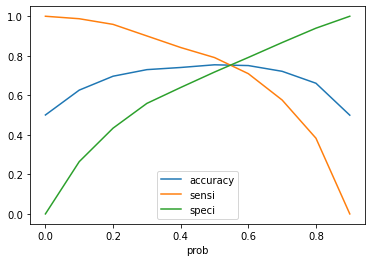

In [68]:
# Now we will plot it
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [69]:
#optimal cutoff is somwehere around 0.55

In [70]:
#0.55 seems to be optimal cutoff
y_train_pred_df['Model_Churn'] = y_train_pred_df.Conversion_Prob.map( lambda x: 1 if x > 0.55 else 0)
y_train_pred_df.head()

,Churn,Conversion_Prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,Model_Churn
0,0,0.503445,1,1,1,1,1,1,0,0,0,0,0
1,1,0.868872,1,1,1,1,1,1,1,1,1,0,1
2,1,0.499627,1,1,1,1,1,0,0,0,0,0,0
3,1,0.776122,1,1,1,1,1,1,1,1,0,0,1
4,0,0.459500,1,1,1,1,1,0,0,0,0,0,0


In [71]:
# Now we will create a ROC function

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [72]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_df.Churn, y_train_pred_df.Conversion_Prob, drop_intermediate = False )

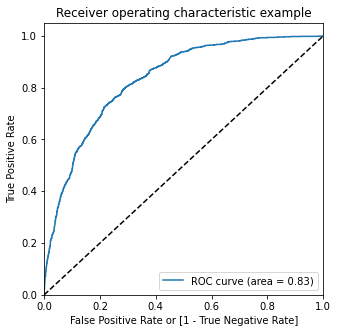

In [73]:
# Now we will call the ROC function
draw_roc(y_train_pred_df.Churn, y_train_pred_df.Conversion_Prob)

In [74]:
# Now we will create the confusion matrix
confusion = metrics.confusion_matrix(y_train_pred_df.Churn, y_train_pred_df.Model_Churn )
print(confusion)

[[3077 1049]
 [ 983 3151]]


In [75]:
# Now we will evaluate our model

TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [76]:
#sensitivity
sensitivity = TP/(TP+FN)
#out of all the predicted churns, how many were actual churns 

# Specificity
specificity = TN/(TN+FP)
#out of all the predicted not-churns, how many were actual not-churns

#precision
precision = TP/(TP+FP)
#out of all the predicted churns,how many times model correctly predicted churn

#accuracy 
accuracy = (TP + TN)/(TP+TN+FP+FN)

#F1 Score
F1 = 2*(precision*sensitivity)/(precision + sensitivity)

print("sensititvity = ",round(sensitivity,2))
print("specificity = ",round(specificity,2))
print("precision = ", round(precision,2))
print("accuracy = ", round(accuracy,2))
print("F1 = ", round(F1,2))

sensititvity =  0.76
specificity =  0.75
precision =  0.75
accuracy =  0.75
F1 =  0.76


In [77]:
#lets see if we can increase the recall. As, acc to the business problem, we need to find out churn customer as much as possible. 
#imporving recall would lead to lower FN. To do this, we may need to lower the threshold so that model predicts more customers
#as churned

In [78]:
#checking the precision and recall tradeoff
from sklearn.metrics import precision_recall_curve

In [79]:
y_train_pred_df.Churn, y_train_pred_df.Model_Churn

(0       0
 1       1
 2       1
 3       1
 4       0
        ..
 8255    1
 8256    1
 8257    0
 8258    0
 8259    0
 Name: Churn, Length: 8260, dtype: int64,
 0       0
 1       1
 2       0
 3       1
 4       0
        ..
 8255    1
 8256    1
 8257    0
 8258    0
 8259    0
 Name: Model_Churn, Length: 8260, dtype: int64)

In [80]:
p, r, thresholds = precision_recall_curve(y_train_pred_df.Churn, y_train_pred_df.Conversion_Prob)

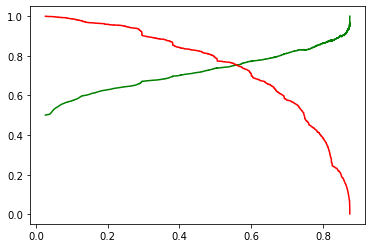

In [81]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

In [82]:
#try new model with 0.5 threshold
y_train_pred_df['Model_Churn'] = y_train_pred_df.Conversion_Prob.map( lambda x: 1 if x > 0.5 else 0)
y_train_pred_df.head()

,Churn,Conversion_Prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,Model_Churn
0,0,0.503445,1,1,1,1,1,1,0,0,0,0,1
1,1,0.868872,1,1,1,1,1,1,1,1,1,0,1
2,1,0.499627,1,1,1,1,1,0,0,0,0,0,0
3,1,0.776122,1,1,1,1,1,1,1,1,0,0,1
4,0,0.459500,1,1,1,1,1,0,0,0,0,0,0


In [83]:
# Now we will create the confusion matrix once again
confusion = metrics.confusion_matrix(y_train_pred_df.Churn, y_train_pred_df.Model_Churn )
print(confusion)

[[2961 1165]
 [ 864 3270]]


In [84]:
# Now we will evaluate our model once again

TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [85]:
#sensitivity
sensitivity = TP/(TP+FN)
#out of all the predicted churns, how many were actual churns 

# Specificity
specificity = TN/(TN+FP)
#out of all the predicted not-churns, how many were actual not-churns

#precision
precision = TP/(TP+FP)
#out of all the predicted churns,how many times model correctly predicted churn

#accuracy 
accuracy = (TP + TN)/(TP+TN+FP+FN)

#F1 Score
F1 = 2*(precision*sensitivity)/(precision + sensitivity)

print("sensititvity = ",round(sensitivity,2))
print("specificity = ",round(specificity,2))
print("precision = ", round(precision,2))
print("accuracy = ", round(accuracy,2))
print("F1 = ", round(F1,2))

sensititvity =  0.79
specificity =  0.72
precision =  0.74
accuracy =  0.75
F1 =  0.76


In [86]:
#try new model with 0.45 threshold
y_train_pred_df['Model_Churn'] = y_train_pred_df.Conversion_Prob.map( lambda x: 1 if x > 0.45 else 0)
y_train_pred_df.head()

,Churn,Conversion_Prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,Model_Churn
0,0,0.503445,1,1,1,1,1,1,0,0,0,0,1
1,1,0.868872,1,1,1,1,1,1,1,1,1,0,1
2,1,0.499627,1,1,1,1,1,0,0,0,0,0,1
3,1,0.776122,1,1,1,1,1,1,1,1,0,0,1
4,0,0.459500,1,1,1,1,1,0,0,0,0,0,1


In [87]:
# Now we will create the confusion matrix once again
confusion = metrics.confusion_matrix(y_train_pred_df.Churn, y_train_pred_df.Model_Churn )
print(confusion)

[[2769 1357]
 [ 719 3415]]


In [88]:
# Now we will evaluate our model once again

TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [89]:
#sensitivity
sensitivity = TP/(TP+FN)
#out of all the predicted churns, how many were actual churns 

# Specificity
specificity = TN/(TN+FP)
#out of all the predicted not-churns, how many were actual not-churns

#precision
precision = TP/(TP+FP)
#out of all the predicted churns,how many times model correctly predicted churn

#accuracy 
accuracy = (TP + TN)/(TP+TN+FP+FN)

#F1 Score
F1 = 2*(precision*sensitivity)/(precision + sensitivity)

print("sensititvity = ",round(sensitivity,2))
print("specificity = ",round(specificity,2))
print("precision = ", round(precision,2))
print("accuracy = ", round(accuracy,2))
print("F1 = ", round(F1,2))

sensititvity =  0.83
specificity =  0.67
precision =  0.72
accuracy =  0.75
F1 =  0.77


In [90]:
#try new model with 0.4 threshold
y_train_pred_df['Model_Churn'] = y_train_pred_df.Conversion_Prob.map( lambda x: 1 if x > 0.4 else 0)
y_train_pred_df.head()

,Churn,Conversion_Prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,Model_Churn
0,0,0.503445,1,1,1,1,1,1,0,0,0,0,1
1,1,0.868872,1,1,1,1,1,1,1,1,1,0,1
2,1,0.499627,1,1,1,1,1,0,0,0,0,0,1
3,1,0.776122,1,1,1,1,1,1,1,1,0,0,1
4,0,0.459500,1,1,1,1,1,0,0,0,0,0,1


In [91]:
# Now we will create the confusion matrix once again
confusion = metrics.confusion_matrix(y_train_pred_df.Churn, y_train_pred_df.Model_Churn )
print(confusion)

[[2639 1487]
 [ 654 3480]]


In [92]:
# Now we will evaluate our model once again

TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [93]:
#sensitivity
sensitivity = TP/(TP+FN)
#out of all the predicted churns, how many were actual churns 

# Specificity
specificity = TN/(TN+FP)
#out of all the predicted not-churns, how many were actual not-churns

#precision
precision = TP/(TP+FP)
#out of all the predicted churns,how many times model correctly predicted churn

#accuracy 
accuracy = (TP + TN)/(TP+TN+FP+FN)

#F1 Score
F1 = 2*(precision*sensitivity)/(precision + sensitivity)

print("sensititvity = ",round(sensitivity,2))
print("specificity = ",round(specificity,2))
print("precision = ", round(precision,2))
print("accuracy = ", round(accuracy,2))
print("F1 = ", round(F1,2))

sensititvity =  0.84
specificity =  0.64
precision =  0.7
accuracy =  0.74
F1 =  0.76


In [94]:
# this shows that highest F1 was at 0.45 threshold, with following results
# 0.55 - senstivity = 0.76, precision = 0.75, F1 = 0.76
# 0.45 - senstivity = 0.83 , precision = 0.72, F1 = 0.77
# 0.40 - senstivity = 0.84 , precision = 0.70, F1 = 0.76

In [95]:
#preparing test set
#scaling the features
X_test[['tenure','MonthlyCharges','TotalCharges']] = scaler.transform(X_test[['tenure','MonthlyCharges','TotalCharges']])
X_test.head()

,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,Contract_One year,...,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
6260,0.169014,0,0,0.170647,0.049804,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3775,0.563380,1,1,0.797512,0.481070,1,1,0,0,0,...,0,0,0,1,0,0,0,1,0,1
866,0.859155,0,1,0.206468,0.267557,1,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
3203,1.000000,1,0,0.694527,0.750288,0,0,1,0,0,...,0,1,0,1,0,1,0,1,0,1
543,0.126761,1,1,0.674627,0.094080,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [96]:
# Now we will select the columns in X_train for X_test as well
X_test = X_test[rfe_col]
X_test.head()

,PaperlessBilling,TotalCharges,Contract_One year,Contract_Two year,PaymentMethod_Electronic check,MultipleLines_No phone service,InternetService_Fiber optic,OnlineSecurity_Yes,StreamingMovies_No internet service
6260,0,0.049804,0,1,0,1,0,0,0
3775,1,0.481070,0,0,1,0,1,0,0
866,1,0.267557,0,1,0,1,0,0,0
3203,0,0.750288,0,1,0,0,0,1,0
543,1,0.094080,0,0,0,0,1,0,0


In [97]:
# Now we will add a constant to X_test
X_test_const = sm.add_constant(X_test)

In [98]:
y_test_pred = round(res.predict(X_test_const),2)

In [99]:
# Now we will convert y_pred to a df
y_pred_df = pd.DataFrame(y_test_pred)
y_pred_df.head()

,0
6260,0.15
3775,0.76
866,0.15
3203,0.03
543,0.80


In [100]:
# Now we will convert y_test to df.
y_test_df = pd.DataFrame(y_test)

In [101]:
# Putting CustID to index
y_test_df['CustID'] = y_test_df.index

In [102]:
# Now we will remove index for both dataframes to append them side by side 
y_pred_df.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [103]:
# Now we will concat y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_df],axis=1)
y_pred_final.head()

,Churn,CustID,0
0,0,6260,0.15
1,1,3775,0.76
2,0,866,0.15
3,0,3203,0.03
4,1,543,0.80


In [104]:
# Now we will rename the column 0 
y_pred_final= y_pred_final.rename(columns = {0 : 'Conv_Prob'})
y_pred_final.head()

,Churn,CustID,Conv_Prob
0,0,6260,0.15
1,1,3775,0.76
2,0,866,0.15
3,0,3203,0.03
4,1,543,0.80


In [105]:
# Now we will make predictions on the test set using 0.45 as the cutoff as we were getting the best precision,recall,and F1 here
y_pred_final['Model_Churn'] = y_pred_final.Conv_Prob.map(lambda x: 1 if x > 0.45 else 0)
y_pred_final.head()

,Churn,CustID,Conv_Prob,Model_Churn
0,0,6260,0.15,0
1,1,3775,0.76,1
2,0,866,0.15,0
3,0,3203,0.03,0
4,1,543,0.80,1


In [106]:
#Making the confusion matrix
confusion_test = metrics.confusion_matrix(y_pred_final['Churn'], y_pred_final.Model_Churn )
print(confusion_test)

[[704 333]
 [178 851]]


In [107]:
TP_test = confusion_test[1,1] # true positive 
TN_test = confusion_test[0,0] # true negatives
FP_test = confusion_test[0,1] # false positives
FN_test = confusion_test[1,0] # false negatives

In [109]:
#sensitivity
sensitivity_test = TP_test/(TP_test+FN_test)
#out of all the predicted churns, how many were actual churns 

# Specificity
specificity_test = TN_test/(TN_test+FP_test)
#out of all the predicted not-churns, how many were actual not-churns

#precision
precision_test = TP_test/(TP_test+FP_test)
#out of all the predicted churns,how many times model correctly predicted churn

#accuracy 
accuracy_test = (TP_test + TN_test)/(TP_test+TN_test+FP_test+FN_test)

#F1 Score
F1_test = 2*(precision_test*sensitivity_test)/(precision_test + sensitivity_test)

print("sensititvity = ",round(sensitivity_test,2))
print("specificity = ",round(specificity_test,2))
print("precision = ", round(precision_test,2))
print("accuracy = ", round(accuracy_test,2))
print("F1 = ", round(F1_test,2))

sensititvity =  0.83
specificity =  0.68
precision =  0.72
accuracy =  0.75
F1 =  0.77


In [ ]:
#Train
#sensititvity =  0.83
#specificity =  0.67
#precision =  0.72
#accuracy =  0.75
#F1 =  0.77